<a href="https://colab.research.google.com/github/lggomezupb/Machine-learning-application-to-portfolio-allocation/blob/main/BL_Portfolio_simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import yfinance as yf
from math import sqrt
from scipy import stats
from scipy.stats import norm
from statsmodels.tsa.stattools import adfuller
import pandas_datareader
import math
import statsmodels.api as sm
import warnings
warnings.filterwarnings("ignore")
from datetime import datetime, timedelta
from prettytable import PrettyTable

In [ ]:
!pip install QuantStats  PyPortfolioOpt

In [ ]:
# Importing libraries for portfolio optimization
from pypfopt.expected_returns import mean_historical_return
from pypfopt.risk_models import CovarianceShrinkage
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt import black_litterman
from pypfopt.black_litterman import BlackLittermanModel
import seaborn as sns
from pypfopt import plotting
from pypfopt import objective_functions
import quantstats as qs
from pypfopt import HRPOpt

In [ ]:
#Total years of traing model
years=2
# Define the end date
fecha = "2022-01-02"
end=fecha
# Convert the end date string to a datetime object
end_date = datetime.strptime(end, "%Y-%m-%d")
# Calculate the start date as one year before the end date
start_date = end_date - timedelta(days=365*years)
# Convert the start date to a string in the same format as the end date
start = start_date.strftime("%Y-%m-%d")

print("Start Date:", start)
print("End Date:", end)

Start Date: 2020-01-03
End Date: 2022-01-02


In [ ]:
## define the stocks for our portfolio (via tickers) ###
assets = [ #Healthcare
          "JNJ", #(Johnson & Johnson)
          "PFE", #(Pfizer Inc.)
          "MRK", #(Merck & Co. Inc.)
          "LLY", #(Eli Lilly and company)
          "UNH", #(UnitedHealth Group Incorporated)
          "AMGN", #(Amgen Inc.)
          #Technology
          "MSFT", #(Microsoft Corporation)
          "GOOGL", #(Alphabet Inc. - Google)
          "META", #(Meta Platforms Inc. - Facebook)
          "NVDA", #(Nvidia)
          "AMD", #(Advanced micro devices)
          "TSLA", #(Tesla, Inc.)
          "CRM", #(Salesforce.com Inc.)
          # Finance
          "JPM", #(JPMorgan Chase & Co.)
          "MA", #(Mastercard)
          "BX", #(Blackstone)
          "AXP", #(American Express)
          "GS", #(The Goldman Sachs Group, Inc.)
          "BAC", #(Bank of America Corporation)
          "V", #(Visa Inc.)
          #Consumer goods
          "PG", #(Procter & Gamble Company)
          "KO", #(The Coca-Cola Company)
          "NKE", #(Nike, Inc.)
          "MCD", #(McDonald's Corporation)
          #Energy
          "XOM", #(Exxon Mobil Corporation)
          "CVX", #(Chevron Corporation)
          "SHEL", #(Royal Dutch Shell plc)
          "BP", #(BP p.l.c.)
          "COP", #(ConocoPhillips)
          #Retail
          "AMZN", #(Amazon.com, Inc.)
          "WMT", #(Walmart Inc.)
          "TGT", #(Target Corporation)
          "COST", #(Costco Wholesale Corporation)
          #"HD", #(The Home Depot, Inc.)
          #Telecommunications
          "T", #(AT&T Inc.)
          "VZ", #(Verizon Communications Inc.)
          "TMUS", #(T-Mobile US, Inc.)
          #Utilities
          "NEE", #(NextEra Energy, Inc.)
          "DUK", #(Duke Energy Corporation)
          "SO", #(The Southern Company)
          "NRG", #(NRG Energy)
          "EXC", #(Exelon Corporation)
          "AEP", #(American Electric Power Company, Inc.)
          #Real Estate
          "SPG", #(Simon Property Group, Inc.)
          "AMT", #(American Tower Corporation)
          "EQIX", #(Equinix, Inc.)
          "PSA", #(Public Storage)
          "WELL", #(Welltower Inc.)
          #Transportation
          "UPS", #(United Parcel Service, Inc.)
          "FDX", #(FedEx Corporation)
          "DAL", #(Delta Air Lines, Inc.)
          "AAL", #(American Airlines Group Inc.)
          "BLDR", #(Builders first source)
          "UBER", #(Uber Technologies, Inc.)
          #"ROAD", #(Construction Partners, Inc)
          #cripto
          "BTC-USD", #Bitcoin
          "ETH-USD" #Ethereum
          ]
#IAU iShares Gold Trust
#MA Mastercard
assets =sorted(assets)
# Acquire data
df_prices = yf.download(assets,start=start,end=end)['Adj Close']
df_prices = df_prices.dropna()

[*********************100%%**********************]  55 of 55 completed


In [ ]:
market_cap_data = {}

# Loop through assets and fetch market cap
for asset in assets:
    try:
        ticker = yf.Ticker(asset)
        info = ticker.info
        market_cap_data[asset] = info['marketCap']
    except Exception as e:
        print(f"Error fetching data for {asset}: {e}")

# Convert the dictionary to a pandas Series
market_cap_series = pd.Series(market_cap_data, name='marketCap')

# Print the market cap series
print(market_cap_series)

AAL           9523440640
AEP          44939190272
AMD         284756770816
AMGN        149842952192
AMT          90073554944
AMZN       1868693110784
AXP         162465988608
BAC         295543930880
BLDR         24280692736
BP          107989934080
BTC-USD    1297317888000
BX          153216712704
COP         153180356608
COST        315894595584
CRM         290999992320
CVX         296550301696
DAL          30187978752
DUK          74770055168
EQIX         75103371264
ETH-USD     396287541248
EXC          37585039360
FDX          67849449472
GOOGL      1906609881088
GS          133721350144
JNJ         377630818304
JPM         573107208192
KO          260826562560
LLY         721678958592
MA          446090313728
MCD         201361981440
META       1246661574656
MRK         329395142656
MSFT       3125688139776
NEE         128584736768
NKE         138080468992
NRG          14733006848
NVDA       2219299831808
PFE         156880666624
PG          377094963200
PSA          49971888128


#Cell block because we have the data from internet

market_cap_data = {
    "AAPL":       2790737313792,
    "AMZN":       1800292139008,
    "AXP":         157749379072,
    "BRK-B":       892726149120,
    "BTC-USD":    1196721176576,
    "CIB":           8007493632,
    "CVX":         282314342400,
    "EC":           24212019200,
    "GOOGL":      1697544011776,
    "HPQ":          28165576704,
    "KO":          259825696768,
    "MA":          445269344256,
    "NU":           52660629504,
    "NVDA":       1954325987328,
    "BAR":         282314342400,
    "IAU":          92780000000,
    "LIT":             48410000,
    "QQQ":         171160000000,
    "REM":            617500000,
    "TLT":          11740000000,
    "VOO":         208200000000,
    "VT":           78700000000
}

# Convert the dictionary to a pandas Series
market_cap_series = pd.Series(market_cap_data, name='marketCap')
market_cap_series=market_cap_series.sort_index()
# Print the market cap series
print(market_cap_series)

In [ ]:
def bl(df_prices):
  # Calculating the annualized expected returns and the annualized sample covariance matrix
  mu = expected_returns.mean_historical_return(df_prices) #expected returns
  S = risk_models.sample_cov(df_prices) #Covariance matrix
  S = pd.DataFrame(S).to_numpy()
  market_prices = yf.download("^GSPC",start = start,
                            end = end)['Adj Close']
  delta = black_litterman.market_implied_risk_aversion(market_prices)
  # Obtaining Prior estimates
  prior = black_litterman.market_implied_prior_returns(market_cap_series,
                                                     delta, S)
  # Inputtig values for vector Q
  Q = np.array([0.27,   # AMZN retorn 54% revisado beto
              0.12,   # AMX will raise by 22%
              0.11])  # MA will raise by 21% valor revisado con beto
  # Number of views (m) and number of assets (n)
  m = 3  # Number of views
  n = len(assets)  # Number of assets

  # Define the views linking to assets
  P = np.zeros((m, n))

  # Define the views and assets preferences
  # Example: Each row corresponds to a view, and each column corresponds to an asset
  # Modify the values as per your preferences
  P[0, 5] = 1  # First view expresses a preference for the first asset # AMZN = 0.056
  P[1, 6] = 1  # Second view expresses a preference for the third asset # AMX = 0.024
  P[2, 29] = 1  # Third view expresses a preference for the fifth asset  # MA =0.041
  # Providing confidence levels
  # Closer to 0.0 = Low confidence
  # Closer to 1.0 = High confidence
  confidences = [0.5,
                0.5,
                0.5]
  # Creating model
  bl = BlackLittermanModel(S, # Covariance Matrix
                          pi = prior, # Prior expected returns
                          Q = Q, # Vector of views
                          P = P, # Matrix mapping the views
                          omega = 'idzorek', # Confidence levels in %
                          view_confidences = confidences) # Confidences

  rets = bl.bl_returns() # Calculating Expected returns
  ef = EfficientFrontier(rets, S) # Optimizing asset allocation
  ef.add_constraint(lambda x: x >= 0.005)  # Minimum allocation for each asset
  ef.add_constraint(lambda x: x >= 0)  # Ensure weights are non-negative
  ef.add_constraint(lambda x : x <= 0.25)  # Limit the maximum weight of each asset to 15%
  ef.max_sharpe() # Optimizing weights for maximal Sharpe ratio
  weights_BL = ef.clean_weights() # Cleaning weights
  BL_model_weight= [weights_BL[i] for i in weights_BL]
  return BL_model_weight


In [ ]:
#Number of periods
periods=26
#Number of days of the period
leng_period=30

assets =sorted(assets)
# Acquire data
df_prices = yf.download(assets,start=start,end=end)['Adj Close']
df_prices = df_prices.dropna()

[*********************100%%**********************]  55 of 55 completed


In [ ]:
#end = "2023-01-02"
weights=[]
table = PrettyTable()
table.field_names = ["Start Date", "End Date"]
for i in range(periods):
  # Convert the end date string to a datetime object
  end_date = datetime.strptime(end, "%Y-%m-%d")
  # Calculate the start date as one year before the end date
  start_date = end_date - timedelta(days=365*years)
  # Convert the start date to a string in the same format as the end date
  start = start_date.strftime("%Y-%m-%d")
  end = end_date.strftime("%Y-%m-%d")
  print(start, end)
  table.add_row([start, end])
  df_prices = yf.download(assets,start=start,end=end)['Adj Close'];
  df_prices = df_prices.dropna()
  weight=bl(df_prices)
  # Append the weights for this period to the matrix
  weights.append(weight)
  end_date += timedelta(days=leng_period)
  end = end_date.strftime("%Y-%m-%d")
print(table)

2020-01-03 2022-01-02


[*********************100%%**********************]  55 of 55 completed
[*********************100%%**********************]  1 of 1 completed


2020-02-02 2022-02-01


[*********************100%%**********************]  55 of 55 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]

2020-03-03 2022-03-03


[*********************100%%**********************]  55 of 55 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]

2020-04-02 2022-04-02


[*********************100%%**********************]  55 of 55 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]

2020-05-02 2022-05-02


[*********************100%%**********************]  55 of 55 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]

2020-06-01 2022-06-01


[*********************100%%**********************]  55 of 55 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]

2020-07-01 2022-07-01


[*********************100%%**********************]  55 of 55 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]

2020-07-31 2022-07-31


[*********************100%%**********************]  55 of 55 completed
[*********************100%%**********************]  1 of 1 completed


2020-08-30 2022-08-30


[*********************100%%**********************]  55 of 55 completed
[*********************100%%**********************]  1 of 1 completed


2020-09-29 2022-09-29


[*********************100%%**********************]  55 of 55 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]

2020-10-29 2022-10-29


[*********************100%%**********************]  55 of 55 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]

2020-11-28 2022-11-28


[*********************100%%**********************]  55 of 55 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]

2020-12-28 2022-12-28


[*********************100%%**********************]  55 of 55 completed
[*********************100%%**********************]  1 of 1 completed


2021-01-27 2023-01-27


[*********************100%%**********************]  55 of 55 completed
[*********************100%%**********************]  1 of 1 completed


2021-02-26 2023-02-26


[*********************100%%**********************]  55 of 55 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]

2021-03-28 2023-03-28


[*********************100%%**********************]  55 of 55 completed
[*********************100%%**********************]  1 of 1 completed


2021-04-27 2023-04-27


[*********************100%%**********************]  55 of 55 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]

2021-05-27 2023-05-27


[*********************100%%**********************]  55 of 55 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]

2021-06-26 2023-06-26


[*********************100%%**********************]  55 of 55 completed
[*********************100%%**********************]  1 of 1 completed


2021-07-26 2023-07-26


[*********************100%%**********************]  55 of 55 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]

2021-08-25 2023-08-25


[*********************100%%**********************]  55 of 55 completed
[*********************100%%**********************]  1 of 1 completed


2021-09-24 2023-09-24


[*********************100%%**********************]  55 of 55 completed
[*********************100%%**********************]  1 of 1 completed


2021-10-24 2023-10-24


[*********************100%%**********************]  55 of 55 completed
[*********************100%%**********************]  1 of 1 completed


2021-11-23 2023-11-23


[*********************100%%**********************]  55 of 55 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]

2021-12-23 2023-12-23


[*********************100%%**********************]  55 of 55 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]

2022-01-22 2024-01-22


[*********************100%%**********************]  55 of 55 completed
[*********************100%%**********************]  1 of 1 completed

+------------+------------+
| Start Date |  End Date  |
+------------+------------+
| 2020-01-03 | 2022-01-02 |
| 2020-02-02 | 2022-02-01 |
| 2020-03-03 | 2022-03-03 |
| 2020-04-02 | 2022-04-02 |
| 2020-05-02 | 2022-05-02 |
| 2020-06-01 | 2022-06-01 |
| 2020-07-01 | 2022-07-01 |
| 2020-07-31 | 2022-07-31 |
| 2020-08-30 | 2022-08-30 |
| 2020-09-29 | 2022-09-29 |
| 2020-10-29 | 2022-10-29 |
| 2020-11-28 | 2022-11-28 |
| 2020-12-28 | 2022-12-28 |
| 2021-01-27 | 2023-01-27 |
| 2021-02-26 | 2023-02-26 |
| 2021-03-28 | 2023-03-28 |
| 2021-04-27 | 2023-04-27 |
| 2021-05-27 | 2023-05-27 |
| 2021-06-26 | 2023-06-26 |
| 2021-07-26 | 2023-07-26 |
| 2021-08-25 | 2023-08-25 |
| 2021-09-24 | 2023-09-24 |
| 2021-10-24 | 2023-10-24 |
| 2021-11-23 | 2023-11-23 |
| 2021-12-23 | 2023-12-23 |
| 2022-01-22 | 2024-01-22 |
+------------+------------+


In [ ]:
start= fecha
start_date = datetime.strptime(start, "%Y-%m-%d")
end_date = start_date + timedelta(days=leng_period*periods)
end = end_date.strftime("%Y-%m-%d")

print("Start Date:", start)
print("End Date:", end)

initial_market_prices = yf.download("^GSPC",start=start,end=end)['Adj Close']
initial_df_prices = yf.download(assets,start=start,end=end)['Adj Close']
initial_df_prices = initial_df_prices.dropna()

[*********************100%%**********************]  1 of 1 completed


Start Date: 2022-01-02
End Date: 2024-02-21


[*********************100%%**********************]  55 of 55 completed


In [ ]:
Total_invest=1_000
Total_invest_market=Total_invest
bl_portfolio = []
market=[]
portfolio=[]
otro=[]
table = PrettyTable()
table.field_names = ["Start Date", "End Date"]
for x in range(periods):
    # Convert the start date string to a datetime object
    start_date = datetime.strptime(start, "%Y-%m-%d")
    #sum leng period to the end date
    end_date = start_date + timedelta(days=leng_period)
    # Convert the end date to a string in the same format as the end date
    end = end_date.strftime("%Y-%m-%d")
    start= start_date.strftime("%Y-%m-%d")
    print(start, end)
    table.add_row([start, end])
    market_prices = yf.download("^GSPC",start=start,end=end)['Adj Close']

    df_prices = yf.download(assets,start=start,end=end)['Adj Close']
    df_prices = df_prices.dropna()
    portfolio= np.zeros(len(df_prices))
    # Loop through each asset and its weight, and calculate the contribution to the portfolio
    for i in range(len(assets)):
        asset_name = assets[i]
        asset_price = df_prices[asset_name]/df_prices[asset_name][0]
        asset_weight = weights[x][i]
        portfolio += asset_price * asset_weight
    portf = portfolio*Total_invest
    # Recalculation of the new total invest by the end of the period
    Total_invest=portfolio[-1]*Total_invest
    bl_portfolio.append(portf)
    market_prices=market_prices/initial_market_prices[0]*Total_invest_market
    market.append(market_prices)
    start_date += timedelta(days=leng_period)
    start= start_date.strftime("%Y-%m-%d")
print(table)

[*********************100%%**********************]  1 of 1 completed


2022-01-02 2022-02-01


[*********************100%%**********************]  55 of 55 completed
[*********************100%%**********************]  1 of 1 completed

2022-02-01 2022-03-03



[*********************100%%**********************]  55 of 55 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]

2022-03-03 2022-04-02


[*********************100%%**********************]  55 of 55 completed
[*********************100%%**********************]  1 of 1 completed


2022-04-02 2022-05-02


[*********************100%%**********************]  55 of 55 completed


2022-05-02 2022-06-01


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  55 of 55 completed
[*********************100%%**********************]  1 of 1 completed


2022-06-01 2022-07-01


[*********************100%%**********************]  55 of 55 completed
[*********************100%%**********************]  1 of 1 completed


2022-07-01 2022-07-31


[*********************100%%**********************]  55 of 55 completed
[*********************100%%**********************]  1 of 1 completed

2022-07-31 2022-08-30



[*********************100%%**********************]  55 of 55 completed
[*********************100%%**********************]  1 of 1 completed

2022-08-30 2022-09-29



[*********************100%%**********************]  55 of 55 completed


2022-09-29 2022-10-29


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  55 of 55 completed
[*********************100%%**********************]  1 of 1 completed

2022-10-29 2022-11-28



[*********************100%%**********************]  55 of 55 completed
[*********************100%%**********************]  1 of 1 completed


2022-11-28 2022-12-28


[*********************100%%**********************]  55 of 55 completed
[*********************100%%**********************]  1 of 1 completed


2022-12-28 2023-01-27


[*********************100%%**********************]  55 of 55 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]

2023-01-27 2023-02-26


[*********************100%%**********************]  55 of 55 completed
[*********************100%%**********************]  1 of 1 completed

2023-02-26 2023-03-28



[*********************100%%**********************]  55 of 55 completed


2023-03-28 2023-04-27


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  55 of 55 completed
[*********************100%%**********************]  1 of 1 completed


2023-04-27 2023-05-27


[*********************100%%**********************]  55 of 55 completed
[*********************100%%**********************]  1 of 1 completed


2023-05-27 2023-06-26


[*********************100%%**********************]  55 of 55 completed
[*********************100%%**********************]  1 of 1 completed


2023-06-26 2023-07-26


[*********************100%%**********************]  55 of 55 completed
[*********************100%%**********************]  1 of 1 completed

2023-07-26 2023-08-25



[*********************100%%**********************]  55 of 55 completed
[*********************100%%**********************]  1 of 1 completed

2023-08-25 2023-09-24



[*********************100%%**********************]  55 of 55 completed
[*********************100%%**********************]  1 of 1 completed

2023-09-24 2023-10-24



[*********************100%%**********************]  55 of 55 completed
[*********************100%%**********************]  1 of 1 completed

2023-10-24 2023-11-23



[*********************100%%**********************]  55 of 55 completed
[*********************100%%**********************]  1 of 1 completed

2023-11-23 2023-12-23



[*********************100%%**********************]  55 of 55 completed
[*********************100%%**********************]  1 of 1 completed


2023-12-23 2024-01-22


[*********************100%%**********************]  55 of 55 completed


2024-01-22 2024-02-21


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  55 of 55 completed


+------------+------------+
| Start Date |  End Date  |
+------------+------------+
| 2022-01-02 | 2022-02-01 |
| 2022-02-01 | 2022-03-03 |
| 2022-03-03 | 2022-04-02 |
| 2022-04-02 | 2022-05-02 |
| 2022-05-02 | 2022-06-01 |
| 2022-06-01 | 2022-07-01 |
| 2022-07-01 | 2022-07-31 |
| 2022-07-31 | 2022-08-30 |
| 2022-08-30 | 2022-09-29 |
| 2022-09-29 | 2022-10-29 |
| 2022-10-29 | 2022-11-28 |
| 2022-11-28 | 2022-12-28 |
| 2022-12-28 | 2023-01-27 |
| 2023-01-27 | 2023-02-26 |
| 2023-02-26 | 2023-03-28 |
| 2023-03-28 | 2023-04-27 |
| 2023-04-27 | 2023-05-27 |
| 2023-05-27 | 2023-06-26 |
| 2023-06-26 | 2023-07-26 |
| 2023-07-26 | 2023-08-25 |
| 2023-08-25 | 2023-09-24 |
| 2023-09-24 | 2023-10-24 |
| 2023-10-24 | 2023-11-23 |
| 2023-11-23 | 2023-12-23 |
| 2023-12-23 | 2024-01-22 |
| 2024-01-22 | 2024-02-21 |
+------------+------------+


In [ ]:
for i in range(periods):
    SP500_earnings = (market[i][-1]-market[i][0])/market[i][0]
    print("Earning % S&P500:", SP500_earnings*100)
    BL_earnings=(bl_portfolio[i][-1]-bl_portfolio[i][0])/bl_portfolio[i][0]
    print("Earning % Black literman portfolio:", BL_earnings*100)

Earning % S&P500: -5.858578866385267
Earning % Black literman portfolio: -10.065299694954952
Earning % S&P500: -3.5191595944460703
Earning % Black literman portfolio: -1.7175490585894317
Earning % S&P500: 4.179443956802417
Earning % Black literman portfolio: 8.662412241145224
Earning % S&P500: -9.835159373003183
Earning % Black literman portfolio: -13.70426528389709
Earning % S&P500: -0.5590338578870564
Earning % Black literman portfolio: -3.46799066651321
Earning % S&P500: -7.701350549967202
Earning % Black literman portfolio: -10.208563204303868
Earning % S&P500: 7.9721214825722235
Earning % Black literman portfolio: 11.33717481125989
Earning % S&P500: -2.137113018043718
Earning % Black literman portfolio: -4.406482803137507
Earning % S&P500: -6.701183066825885
Earning % Black literman portfolio: -7.611007156699895
Earning % S&P500: 7.158144140392246
Earning % Black literman portfolio: 4.925434647494833
Earning % S&P500: 3.980912543356939
Earning % Black literman portfolio: 2.1547149

In [ ]:
SP500_earnings = (market[-1][-1]-market[0][0])/market[0][0]
print("Earning % S&P500:", SP500_earnings*100)
BL_earnings=(bl_portfolio[-1][-1]-bl_portfolio[0][0])/bl_portfolio[0][0]
print("Earning % Black literman portfolio:", BL_earnings*100)

Earning % S&P500: 3.730792585628842
Earning % Black literman portfolio: -2.7089796030214943


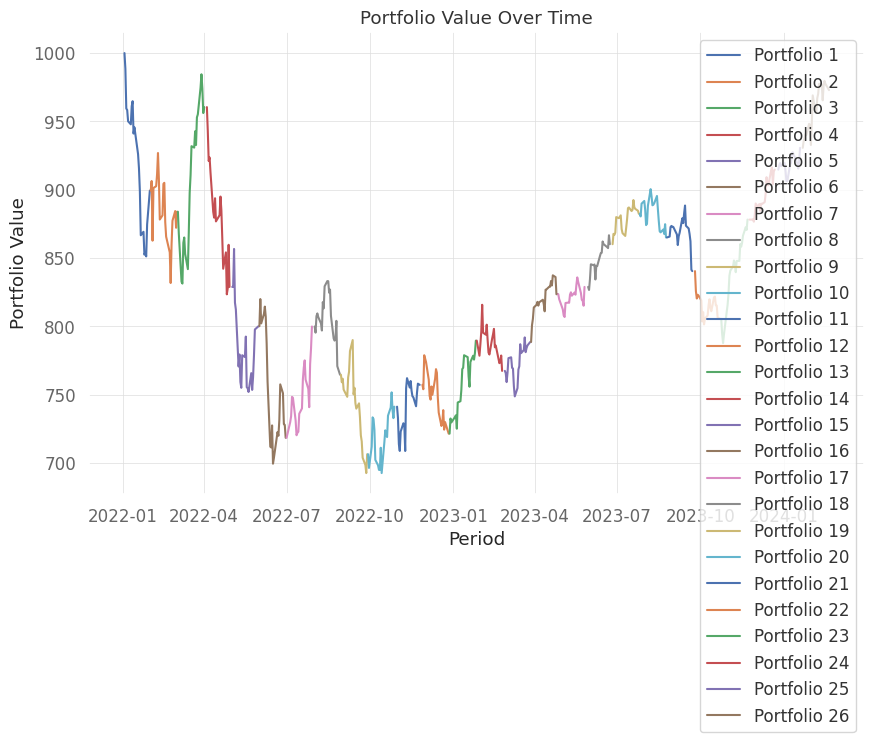

In [ ]:
# Plot each array in bl_portfolio
for i, portfolio_values in enumerate(bl_portfolio):
    plt.plot(portfolio_values, label=f'Portfolio {i+1}')



plt.xlabel('Period')
plt.ylabel('Portfolio Value')
plt.title('Portfolio Value Over Time')
plt.legend()
plt.show()

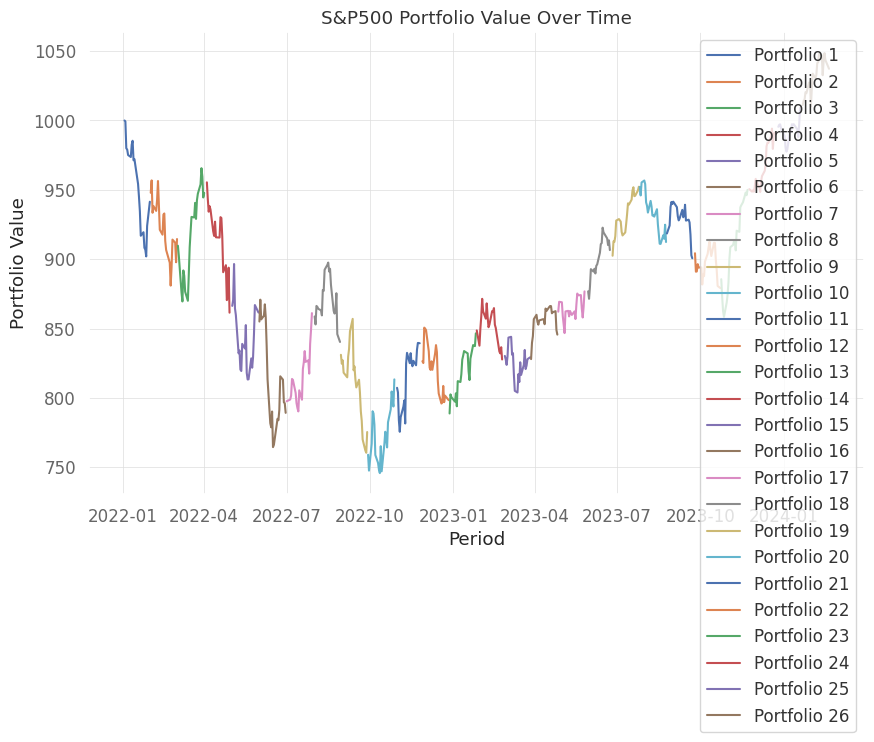

In [ ]:
# Plot each array in bl_portfolio
for i, portfolio_values in enumerate(market):
    plt.plot(portfolio_values, label=f'Portfolio {i+1}')

plt.xlabel('Period')
plt.ylabel('Portfolio Value')
plt.title('S&P500 Portfolio Value Over Time')
plt.legend()
plt.show()

In [ ]:
#convert to a dataframe
df_portfolio=pd.DataFrame(bl_portfolio)
# Replace all the nan to value 0. When you do a dataframe it will create several row per each run and the columns are the dates
df_portfolio.fillna(0, inplace=True)
#transpose to have the date as row and all the run as columns
df_portfolio = df_portfolio.transpose()
#sum all the columns in the same row to have and unique value per row
df_portfolio = df_portfolio.sum(axis=1)

start= fecha
start_date = datetime.strptime(start, "%Y-%m-%d")
end_date = start_date + timedelta(days=leng_period*periods)
end = end_date.strftime("%Y-%m-%d")
sp500 = yf.download("^GSPC",start=start,end=end)['Adj Close']
market=sp500/sp500[0]*Total_invest_market

[*********************100%%**********************]  1 of 1 completed


<Axes: xlabel='Date'>

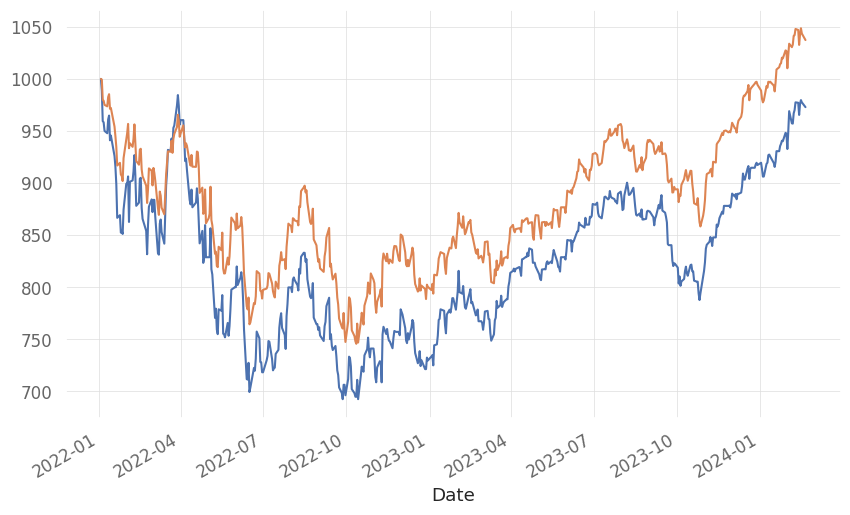

In [ ]:
df_portfolio.plot()
market.plot()

In [ ]:
df=pd.DataFrame(weights, columns=assets)

In [ ]:
import plotly.express as px

# Assuming df is your DataFrame with data
fig = px.bar(df, barmode='stack')


fig.update_layout(
    title='Stacked Bar Chart',
    xaxis=dict(title='Category'),
    yaxis=dict(title='Values'),
    legend=dict(title='Assets'),
)

# Create dropdown menu for variable selection
buttons = [
    dict(label=var, method='update', args=[{'visible': [col == var for col in df.columns]}])
    for var in df.columns
]
# Add an option to reset the graph
buttons.append(
    dict(label="Reset", method="update", args=[{'visible': [True] * len(df.columns)}])
)

fig.update_layout(
    updatemenus=[
        dict(
            buttons=buttons,
            direction='down',
            showactive=True,
            x=0.1,
            xanchor='left',
            y=1.15,
            yanchor='top'
        ),
    ]
)

fig.show()

## Simulacion hoy

In [ ]:
def bl(df_prices):
  # Calculating the annualized expected returns and the annualized sample covariance matrix
  mu = expected_returns.mean_historical_return(df_prices) #expected returns
  S = risk_models.sample_cov(df_prices) #Covariance matrix
  S = pd.DataFrame(S).to_numpy()
  market_prices = yf.download("^GSPC",start = start,
                            end = end)['Adj Close']
  delta = black_litterman.market_implied_risk_aversion(market_prices)
  # Obtaining Prior estimates
  prior = black_litterman.market_implied_prior_returns(market_cap_series,
                                                     delta, S)
  # Inputtig values for vector Q
  Q = np.array([0.27,   # AMZN retorn 54% revisado beto
              0.12,   # AMX will raise by 22%
              0.11])  # MA will raise by 21% valor revisado con beto
  # Number of views (m) and number of assets (n)
  m = 3  # Number of views
  n = len(assets)  # Number of assets

  # Define the views linking to assets
  P = np.zeros((m, n))

  # Define the views and assets preferences
  # Example: Each row corresponds to a view, and each column corresponds to an asset
  # Modify the values as per your preferences
  P[0, 5] = 1  # First view expresses a preference for the first asset # AMZN = 0.056
  P[1, 6] = 1  # Second view expresses a preference for the third asset # AMX = 0.024
  P[2, 29] = 1  # Third view expresses a preference for the fifth asset  # MA =0.041
  # Providing confidence levels
  # Closer to 0.0 = Low confidence
  # Closer to 1.0 = High confidence
  confidences = [0.5,
                0.5,
                0.5]
  # Creating model
  bl = BlackLittermanModel(S, # Covariance Matrix
                          pi = prior, # Prior expected returns
                          Q = Q, # Vector of views
                          P = P, # Matrix mapping the views
                          omega = 'idzorek', # Confidence levels in %
                          view_confidences = confidences) # Confidences

  rets = bl.bl_returns() # Calculating Expected returns
  ef = EfficientFrontier(rets, S) # Optimizing asset allocation
  #ef.add_constraint(lambda x : x >= 0)  # Ensure weights are non-negative
  #ef.add_constraint(lambda x : x <= 0.25)  # Limit the maximum weight of each asset to 15%
  ef.add_constraint(lambda x: x >= .005)  # Allow weights to be either 0 or between 0.01 and 0.25
  ef.max_sharpe() # Optimizing weights for maximal Sharpe ratio
  weights_BL = ef.clean_weights() # Cleaning weights
  BL_model_weight= [weights_BL[i] for i in weights_BL]
  return BL_model_weight

In [ ]:
start="2023-01-02"
end= "2024-03-18"
df_prices = yf.download(assets,start=start,end=end)['Adj Close'];
df_prices = df_prices.dropna()
weight=bl(df_prices)

[*********************100%%**********************]  55 of 55 completed
[*********************100%%**********************]  1 of 1 completed


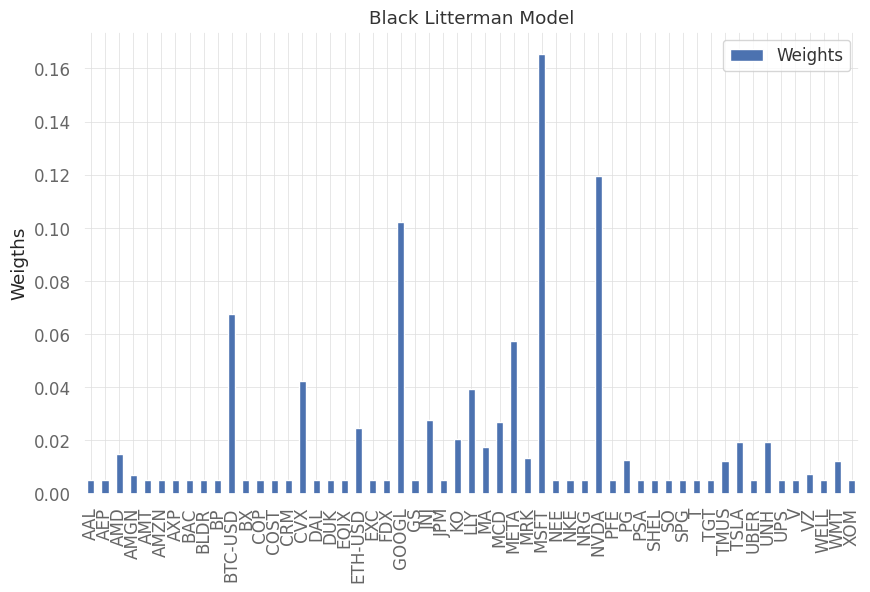

In [ ]:
df=pd.DataFrame({'Weights': weight,'Assets': assets}, index=assets)
df.plot(kind="bar", title='Black Litterman Model',ylabel='Weigths');

In [ ]:
fig = px.bar(df, x="Assets", y="Weights", barmode="group")
fig.show()